[![lamindata](https://img.shields.io/badge/laminlabs/rxrx-mediumseagreen)](https://lamin.ai/laminlabs/rxrx/record/core/Transform?id=Zo0qJt4IQPsbz8)

# Register the RxRx1 dataset

In [1]:
!lamin load falexwolf/rxrx

💡 loading db URL from local cache
💡 loaded instance: falexwolf/rxrx


In [1]:
import lamindb as ln
import lnschema_bionty as lb
import lnschema_lamin1 as ln1

💡 loaded instance: falexwolf/rxrx (lamindb 0.59.4)


In [4]:
ln.track()

💡 notebook imports: lamindb==0.59.0 lnschema_bionty==0.31.2 lnschema_lamin1==0.23.2
💡 Transform(uid='Zo0qJt4IQPsbz8', name='Register the RxRx1 dataset', short_name='02-rxrx1', version='0', type='notebook', updated_at=2023-11-05 17:52:03 UTC, created_by_id=1)
💡 Run(uid='uDTcsSkasQ136KTywYJN', run_at=2023-11-06 19:30:53 UTC, transform_id=3, created_by_id=1)
💡   parent transform: Transform(uid='VxfLdk7rOTnbz8', name='Download metadata & embeddings of RxRx1', short_name='01-download', version='0', type='notebook', updated_at=2023-11-05 16:03:19 UTC, latest_report_id=4, source_file_id=3, created_by_id=1)


## Load metadata

We read in the metadata of the wells:

In [4]:
meta_file = ln.File.filter(key="rxrx1/metadata.csv").one()
meta = meta_file.load()

💡 adding file [1] as input for run 2, adding parent transform 2


In [5]:
meta.shape

(125510, 11)

In [6]:
meta.head(5)

,site_id,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138
2,HEPG2-08_1_B03_1,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,1,treatment,s21721,855
3,HEPG2-08_1_B03_2,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,2,treatment,s21721,855
4,HEPG2-08_1_B04_1,HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,B04,1,treatment,s20894,710


It seems that the column storing cell lines is erroneously called `cell_type`. 

Also `dataset` refers to something that's more often called `split`.

Let us rename it: 

In [7]:
meta.rename({"cell_type": "cell_line", "dataset": "split"}, axis=1, inplace=True)

Now this is fixed:

In [8]:
meta.head(5)

,site_id,well_id,cell_line,split,experiment,plate,well,site,well_type,sirna,sirna_id
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138
2,HEPG2-08_1_B03_1,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,1,treatment,s21721,855
3,HEPG2-08_1_B03_2,HEPG2-08_1_B03,HEPG2,test,HEPG2-08,1,B03,2,treatment,s21721,855
4,HEPG2-08_1_B04_1,HEPG2-08_1_B04,HEPG2,test,HEPG2-08,1,B04,1,treatment,s20894,710


Add a `paths` column - this is an aggregate over 6 paths for 6 channels. We'll deconvolute further down:

In [9]:
paths = []
for _, row in meta.iterrows():
    well = row.well
    site = row.site
    paths.append(
        f"images/{row.split}/{row.experiment}/Plate{row.plate}/{well}_s{site}_w1-w6.png"
    )
meta["paths"] = paths

In [10]:
meta.head(2)

,site_id,well_id,cell_line,split,experiment,plate,well,site,well_type,sirna,sirna_id,paths
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1-w6.png
1,HEPG2-08_1_B02_2,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,2,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s2_w1-w6.png


## Validate and register metadata

### `cell_line`

We can start with curating the metadata table based on the ontologies from bionty. For example, let's start with the `cell_line` metadata.
In this table, they are called "cell_type" but they are in fact the cell line for the experiments

In [11]:
meta["cell_line"].unique()

array(['HEPG2', 'HUVEC', 'RPE', 'U2OS'], dtype=object)

In [12]:
cell_lines = lb.CellLine.from_values(meta["cell_line"])

✅ loaded 4 CellLine records matching synonyms: 'HEPG2', 'HUVEC', 'RPE', 'U2OS'


In [13]:
ln.save(cell_lines)

Define and abbreviation:

In [14]:
lb.CellLine.filter().df()

,uid,name,ontology_id,abbr,synonyms,description,bionty_source_id,updated_at,created_by_id
id,,,,,,,,,
5,br5GPP6q,immortal human liver-derived cell line cell,CLO:0000565,None,None,An immortal liver-derived cell line cell that ...,20,2023-11-05 16:48:53.001607+00:00,1
6,XPqCzHAi,immortal liver-derived cell line cell,CLO:0000235,None,None,An immortal cell line cell that derives from l...,20,2023-11-05 16:48:55.038999+00:00,1
7,0mXEmtun,immortal cell line cell,CLO:0000019,None,continuous cell line cell|permanent cell line ...,A cell line cell that is expected to be capabl...,20,2023-11-05 16:48:57.216582+00:00,1
8,iaqgKEYY,cell line cell,CLO:0000001,None,None,A cultured cell that is part of a cell line - ...,20,2023-11-05 16:48:59.238837+00:00,1
9,CkFSX9KW,immortal human vasculature-derived endothelial...,CLO:0037232,None,None,An immortal vasculature-derived cell line cell...,20,2023-11-05 16:49:03.211122+00:00,1
10,QrS3iIgW,immortal vasculature-derived cell line cell,CLO:0000208,None,None,An immortal cell line cell that derives from v...,20,2023-11-05 16:49:05.336438+00:00,1
11,DuJQ6bfB,immortal human vasculature-derived cell line cell,CLO:0000853,None,None,An immortal vasculature-derived cell line cell...,20,2023-11-05 16:49:05.336458+00:00,1
12,TN6tllJM,immortal human eye-derived cell line cell,CLO:0000876,None,None,An immortal eye-derived cell line cell that de...,20,2023-11-05 16:49:09.871894+00:00,1
13,myWpIoSa,immortal eye-derived cell line cell,CLO:0000271,None,None,An immortal cell line cell that derives from eye.,20,2023-11-05 16:49:12.000742+00:00,1


In [15]:
lb.CellLine.filter(uid="a3uzySL7").one().set_abbr("HUVEC")
lb.CellLine.filter(uid="9dcEG64P").one().set_abbr("U2OS")
lb.CellLine.filter(uid="KQYkiVUX").one().set_abbr("RPE")
lb.CellLine.filter(uid="AkJL1qhy").one().set_abbr("HEPG2")

In [16]:
lb.CellLine.filter().df()

,uid,name,ontology_id,abbr,synonyms,description,bionty_source_id,updated_at,created_by_id
id,,,,,,,,,
5,br5GPP6q,immortal human liver-derived cell line cell,CLO:0000565,None,None,An immortal liver-derived cell line cell that ...,20,2023-11-05 16:48:53.001607+00:00,1
6,XPqCzHAi,immortal liver-derived cell line cell,CLO:0000235,None,None,An immortal cell line cell that derives from l...,20,2023-11-05 16:48:55.038999+00:00,1
7,0mXEmtun,immortal cell line cell,CLO:0000019,None,continuous cell line cell|permanent cell line ...,A cell line cell that is expected to be capabl...,20,2023-11-05 16:48:57.216582+00:00,1
8,iaqgKEYY,cell line cell,CLO:0000001,None,None,A cultured cell that is part of a cell line - ...,20,2023-11-05 16:48:59.238837+00:00,1
9,CkFSX9KW,immortal human vasculature-derived endothelial...,CLO:0037232,None,None,An immortal vasculature-derived cell line cell...,20,2023-11-05 16:49:03.211122+00:00,1
10,QrS3iIgW,immortal vasculature-derived cell line cell,CLO:0000208,None,None,An immortal cell line cell that derives from v...,20,2023-11-05 16:49:05.336438+00:00,1
11,DuJQ6bfB,immortal human vasculature-derived cell line cell,CLO:0000853,None,None,An immortal vasculature-derived cell line cell...,20,2023-11-05 16:49:05.336458+00:00,1
12,TN6tllJM,immortal human eye-derived cell line cell,CLO:0000876,None,None,An immortal eye-derived cell line cell that de...,20,2023-11-05 16:49:09.871894+00:00,1
13,myWpIoSa,immortal eye-derived cell line cell,CLO:0000271,None,None,An immortal cell line cell that derives from eye.,20,2023-11-05 16:49:12.000742+00:00,1


In [17]:
cell_lines = lb.CellLine.lookup(field="abbr")

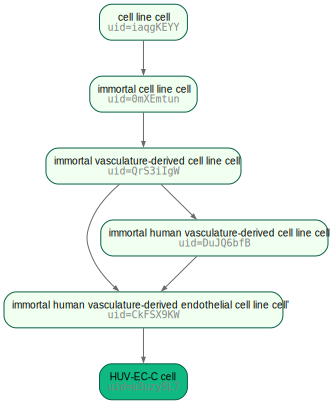

In [18]:
cell_lines.huvec.view_parents()

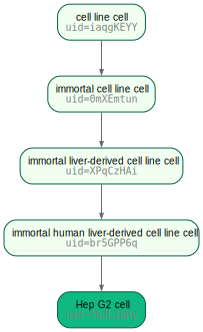

In [19]:
cell_lines.hepg2.view_parents()

### `split`

Use `ULabel` for "train", "test":

In [20]:
meta["split"].unique()

array(['test', 'train'], dtype=object)

In [21]:
train_test = [
    ln.ULabel(name=name, description="ML split") for name in meta["split"].unique()
]
ln.save(train_test)

✅ loaded ULabel record with exact same name: 'test'
✅ loaded ULabel record with exact same name: 'train'


Define a parent:

In [22]:
is_split = ln.ULabel(name="is_split", description="ML split")
is_split.save()
is_split.children.add(*train_test)

✅ loaded ULabel record with exact same name: 'is_split'


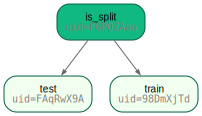

In [23]:
is_split.view_parents(with_children=True)

### `experiment`

In [24]:
ln.settings.upon_create_search_name = False
experiments = [
    ln1.Experiment(name=name, description="RxRx1")
    for name in meta["experiment"].unique()
]
ln.save(experiments)
ln.settings.upon_create_search_name = True

✅ loaded Experiment record with exact same name: 'HEPG2-08'
✅ loaded Experiment record with exact same name: 'HEPG2-09'
✅ loaded Experiment record with exact same name: 'HEPG2-10'
✅ loaded Experiment record with exact same name: 'HEPG2-11'
✅ loaded Experiment record with exact same name: 'HUVEC-17'
✅ loaded Experiment record with exact same name: 'HUVEC-18'
✅ loaded Experiment record with exact same name: 'HUVEC-19'
✅ loaded Experiment record with exact same name: 'HUVEC-20'
✅ loaded Experiment record with exact same name: 'HUVEC-21'
✅ loaded Experiment record with exact same name: 'HUVEC-22'
✅ loaded Experiment record with exact same name: 'HUVEC-23'
✅ loaded Experiment record with exact same name: 'HUVEC-24'
✅ loaded Experiment record with exact same name: 'RPE-08'
✅ loaded Experiment record with exact same name: 'RPE-09'
✅ loaded Experiment record with exact same name: 'RPE-10'
✅ loaded Experiment record with exact same name: 'RPE-11'
✅ loaded Experiment record with exact same name:

### `plate`

In [25]:
is_plate = ln.ULabel(name="is_plate", description="parent of plates")
is_plate.save()

✅ loaded ULabel record with exact same name: 'is_plate'


In [26]:
plates = [ln.ULabel(name=f"Plate{name}") for name in meta["plate"].unique()]
ln.save(plates)
is_plate.children.set(plates)

✅ loaded ULabel record with exact same name: 'Plate1'
✅ loaded ULabel record with exact same name: 'Plate2'
✅ loaded ULabel record with exact same name: 'Plate3'
✅ loaded ULabel record with exact same name: 'Plate4'


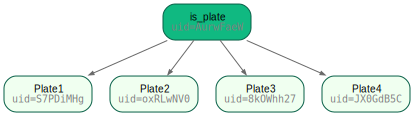

In [27]:
is_plate.view_parents(with_children=True)

### `well`

We might also want to add the well information, so that we can link image files and parse images based on well coordinates. To do this, let's first extract well locations from the table:

In [28]:
ln.settings.upon_create_search_name = False
wells = [
    ln1.Well(name=well, row=well[0], column=int(well[1:]))
    for well in meta["well"].unique()
]
ln.save(wells)
ln.settings.upon_create_search_name = True

✅ loaded Well record with exact same name: 'B02'
✅ loaded Well record with exact same name: 'B03'
✅ loaded Well record with exact same name: 'B04'
✅ loaded Well record with exact same name: 'B05'
✅ loaded Well record with exact same name: 'B06'
✅ loaded Well record with exact same name: 'B07'
✅ loaded Well record with exact same name: 'B08'
✅ loaded Well record with exact same name: 'B09'
✅ loaded Well record with exact same name: 'B10'
✅ loaded Well record with exact same name: 'B11'
✅ loaded Well record with exact same name: 'B12'
✅ loaded Well record with exact same name: 'B13'
✅ loaded Well record with exact same name: 'B14'
✅ loaded Well record with exact same name: 'B15'
✅ loaded Well record with exact same name: 'B16'
✅ loaded Well record with exact same name: 'B17'
✅ loaded Well record with exact same name: 'B18'
✅ loaded Well record with exact same name: 'B19'
✅ loaded Well record with exact same name: 'B20'
✅ loaded Well record with exact same name: 'B21'
✅ loaded Well record

### `well_type`

In [29]:
is_well_type = ln.ULabel(name="is_well_type", description="parent of well types")
is_well_type.save()

✅ loaded ULabel record with exact same name: 'is_well_type'


In [30]:
well_types = [ln.ULabel(name=name) for name in meta["well_type"].unique()]
ln.save(well_types)
is_well_type.children.set(well_types)

✅ loaded ULabel record with exact same name: 'negative_control'
✅ loaded ULabel record with exact same name: 'treatment'
✅ loaded ULabel record with exact same name: 'positive_control'


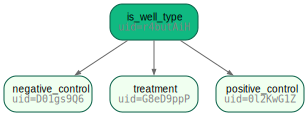

In [31]:
is_well_type.view_parents(with_children=True)

### `sirna`

Add `sirna` to Treatment table:

In [32]:
ln.settings.upon_create_search_name = False
sirnas = [
    ln1.Treatment(
        name=sirna,
        type="genetic",
        system="siRNA",
        description="ThermoFisher ID of siRNA",
    )
    for sirna in meta["sirna"].unique()
]
ln.save(sirnas)
ln.settings.upon_create_search_name = True

✅ loaded Treatment record with exact same name: 'EMPTY'
✅ loaded Treatment record with exact same name: 's21721'
✅ loaded Treatment record with exact same name: 's20894'
✅ loaded Treatment record with exact same name: 's19827'
✅ loaded Treatment record with exact same name: 's19792'
✅ loaded Treatment record with exact same name: 's19935'
✅ loaded Treatment record with exact same name: 's21398'
✅ loaded Treatment record with exact same name: 's223097'
✅ loaded Treatment record with exact same name: 's348'
✅ loaded Treatment record with exact same name: 's19975'
✅ loaded Treatment record with exact same name: 's19911'
✅ loaded Treatment record with exact same name: 's21543'
✅ loaded Treatment record with exact same name: 's195030'
✅ loaded Treatment record with exact same name: 's20290'
✅ loaded Treatment record with exact same name: 's20345'
✅ loaded Treatment record with exact same name: 's20305'
✅ loaded Treatment record with exact same name: 's20110'
✅ loaded Treatment record with e

### `readout`

In [50]:
ln.Feature(name="readout", type="category").save()

✅ loaded Feature record with exact same name: 'readout'


In [34]:
readout = lb.ExperimentalFactor.from_bionty(name="high content screen")
readout.save()

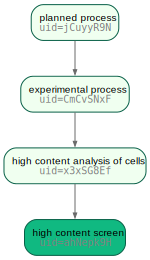

In [35]:
readout.view_parents(with_children=True)

## Register metadata-path as a parquet file:

Here we create a DataFrame with each row as a single image, similar to a link table but with multiple metadata columns:

In [36]:
meta_filekey = meta.copy()

In [37]:
keys_list = []
for key in meta_filekey["paths"]:
    keys = [key.replace("w1-w6.png", f"w{str(channel)}.png") for channel in range(1, 7)]
    keys_list.append(keys)

In [38]:
meta_filekey["path"] = keys_list

In [39]:
meta_filekey = meta_filekey.explode("path").reset_index(drop=True)

In [40]:
meta_filekey

,site_id,well_id,cell_line,split,experiment,plate,well,site,well_type,sirna,sirna_id,paths,path
0,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1-w6.png,images/test/HEPG2-08/Plate1/B02_s1_w1.png
1,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1-w6.png,images/test/HEPG2-08/Plate1/B02_s1_w2.png
2,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1-w6.png,images/test/HEPG2-08/Plate1/B02_s1_w3.png
3,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1-w6.png,images/test/HEPG2-08/Plate1/B02_s1_w4.png
4,HEPG2-08_1_B02_1,HEPG2-08_1_B02,HEPG2,test,HEPG2-08,1,B02,1,negative_control,EMPTY,1138,images/test/HEPG2-08/Plate1/B02_s1_w1-w6.png,images/test/HEPG2-08/Plate1/B02_s1_w5.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
753055,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w1-w6.png,images/train/U2OS-03/Plate4/O23_s2_w2.png
753056,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w1-w6.png,images/train/U2OS-03/Plate4/O23_s2_w3.png
753057,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w1-w6.png,images/train/U2OS-03/Plate4/O23_s2_w4.png
753058,U2OS-03_4_O23_2,U2OS-03_4_O23,U2OS,train,U2OS-03,4,O23,2,treatment,s21454,509,images/train/U2OS-03/Plate4/O23_s2_w1-w6.png,images/train/U2OS-03/Plate4/O23_s2_w5.png


## Register all metadata features

In [41]:
obs_features = ln.Feature.from_df(
    meta_filekey[
        [
            "cell_line",
            "split",
            "experiment",
            "plate",
            "well",
            "well_type",
            "sirna",
            "path",
        ]
    ]
)
ln.save(obs_features)

In [42]:
ln.Feature.filter().df()

,uid,name,type,modality_id,unit,description,registries,synonyms,updated_at,created_by_id
id,,,,,,,,,,
4,QRDI6GPwJXUi,cell_line,category,None,None,None,bionty.CellLine,None,2023-11-05 17:08:02.833049+00:00,1
5,7Fu3r6Oqlu54,split,category,None,None,None,core.ULabel,None,2023-11-05 17:08:04.072217+00:00,1
6,oJ4yMuWHSyHN,experiment,category,None,None,None,lamin1.Experiment,None,2023-11-05 17:08:05.213061+00:00,1
7,kCK1qPgf3koy,plate,number,None,None,None,core.ULabel,None,2023-11-05 17:08:06.439267+00:00,1
8,qka3fPyvXUhM,well,category,None,None,None,lamin1.Well,None,2023-11-05 17:08:07.581034+00:00,1
10,MeViaVFT7MMO,well_type,category,None,None,None,core.ULabel,None,2023-11-05 17:08:10.088877+00:00,1
11,o9daNbNPBP8t,sirna,category,None,None,None,lamin1.Treatment,None,2023-11-05 17:08:11.289557+00:00,1
14,Fqt7swNFOXdV,path,object,None,None,None,None,None,2023-11-05 17:57:28.857915+00:00,1
1,xjFyZiG6VjzJ,readout,category,None,None,None,bionty.ExperimentalFactor,None,2023-11-05 18:06:45.527101+00:00,1


In [43]:
features = ln.Feature.lookup()

## Register file

In [44]:
file_meta_filekey = ln.File.from_df(
    meta_filekey,
    field=ln.Feature.name,
    key="rxrx1/metadata.parquet",
    description="Metadata with file paths for each RxRx1 image.",
)

❗ returning existing file with same hash: File(uid='flLeukogmLRzleFCpCRD', key='rxrx1/metadata.parquet', suffix='.parquet', accessor='DataFrame', description='Metadata with file paths for each RxRx1 image.', size=7806003, hash='4on4AbbmBL0sr0xe9_gxxQ', hash_type='md5', visibility=0, key_is_virtual=True, updated_at=2023-11-05 17:59:23 UTC, storage_id=1, transform_id=3, run_id=2, created_by_id=1)
✅ 8 terms (61.50%) are validated for name
❗ 5 terms (38.50%) are not validated for name: site_id, well_id, site, sirna_id, paths
✅ loaded: FeatureSet(uid='y0uhIW520iTEzrxI14mL', n=8, registry='core.Feature', hash='mnhzsJj-j7VZgNJ88VM0', updated_at=2023-11-05 17:57:58 UTC, created_by_id=1)


In [45]:
file_meta_filekey.save()

Annotate with labels:

In [46]:
cell_lines = lb.CellLine.from_values(meta.cell_line.unique())

✅ loaded 4 CellLine records matching synonyms: 'HEPG2', 'HUVEC', 'RPE', 'U2OS'


In [47]:
# obs
file_meta_filekey.labels.add(cell_lines, features.cell_line)
file_meta_filekey.labels.add(train_test, features.split)
file_meta_filekey.labels.add(experiments, features.experiment)
file_meta_filekey.labels.add(plates, features.plate)
file_meta_filekey.labels.add(wells, features.well)
file_meta_filekey.labels.add(well_types, features.well_type)
file_meta_filekey.labels.add(sirnas, features.sirna)

In [48]:
# external
file_meta_filekey.labels.add(readout, features.readout)

✅ loaded: FeatureSet(uid='JWcRhQneUEwjkoYnEf59', n=1, registry='core.Feature', hash='AF42DRsoUacKb5l4WgT-', updated_at=2023-11-05 17:08:29 UTC, modality_id=1, created_by_id=1)
✅ linked new feature 'readout' together with new feature set FeatureSet(uid='JWcRhQneUEwjkoYnEf59', n=1, registry='core.Feature', hash='AF42DRsoUacKb5l4WgT-', updated_at=2023-11-05 18:07:05 UTC, modality_id=1, created_by_id=1)


In [49]:
file_meta_filekey.describe()

File(uid='flLeukogmLRzleFCpCRD', key='rxrx1/metadata.parquet', suffix='.parquet', accessor='DataFrame', description='Metadata with file paths for each RxRx1 image.', size=7806003, hash='4on4AbbmBL0sr0xe9_gxxQ', hash_type='md5', visibility=0, key_is_virtual=True, updated_at=2023-11-05 18:06:55 UTC)

Provenance:
  🗃️ storage: Storage(uid='DxIABGjc', root='s3://lamindata', type='s3', region='us-east-1', updated_at=2023-11-05 15:57:55 UTC, created_by_id=1)
  📔 transform: Transform(uid='Zo0qJt4IQPsbz8', name='Register the RxRx1 dataset', short_name='02-rxrx1', version='0', type='notebook', updated_at=2023-11-05 17:52:03 UTC, created_by_id=1)
  👣 run: Run(uid='uDTcsSkasQ136KTywYJN', run_at=2023-11-05 18:00:29 UTC, transform_id=3, created_by_id=1)
  👤 created_by: User(uid='FBa7SHjn', handle='falexwolf', name='Alex Wolf', updated_at=2023-11-05 14:57:57 UTC)
Features:
  columns: FeatureSet(uid='y0uhIW520iTEzrxI14mL', n=8, registry='core.Feature', hash='mnhzsJj-j7VZgNJ88VM0', updated_at=2023-11-

## Register images with metadata as dataset

In [4]:
dataset = ln.Dataset(
    "gs://rxrx1-europe-west4/images", name="RxRx1 images", meta=meta_file
)

❗ no run & transform get linked, consider passing a `run` or calling ln.track()
❗ returning existing dataset with same hash: Dataset(uid='3ZvDJI6WuhiW5l9IGevZ', name='RxRx1 images', visibility=0, updated_at=2023-11-06 19:31:49 UTC, transform_id=3, run_id=2, file_id=6, storage_id=2, created_by_id=1)


In [7]:
dataset.save()

In [8]:
dataset

Dataset(uid='3ZvDJI6WuhiW5l9IGevZ', name='RxRx1 images', visibility=0, updated_at=2023-11-06 19:37:06 UTC, transform_id=3, run_id=2, file_id=6, storage_id=2, created_by_id=1)

In [9]:
dataset.path

GCSPath('gs://rxrx1-europe-west4/images')

## Link dataset to metadata records

In [10]:
dataset.labels.add_from(meta_file)

In [11]:
dataset.describe()

Dataset(uid='3ZvDJI6WuhiW5l9IGevZ', name='RxRx1 images', visibility=0, updated_at=2023-11-06 19:37:06 UTC)

Provenance:
  📔 transform: Transform(uid='Zo0qJt4IQPsbz8', name='Register the RxRx1 dataset', short_name='02-rxrx1', version='0', type='notebook', updated_at=2023-11-05 17:52:03 UTC, created_by_id=1)
  👣 run: Run(uid='uDTcsSkasQ136KTywYJN', run_at=2023-11-06 19:30:53 UTC, transform_id=3, created_by_id=1)
  📄 file: File(uid='flLeukogmLRzleFCpCRD', key='rxrx1/metadata.parquet', suffix='.parquet', accessor='DataFrame', description='Metadata with file paths for each RxRx1 image.', size=7806003, hash='4on4AbbmBL0sr0xe9_gxxQ', hash_type='md5', visibility=0, key_is_virtual=True, updated_at=2023-11-06 19:37:06 UTC, storage_id=1, transform_id=3, run_id=2, created_by_id=1)
  🗃️ storage: Storage(uid='aLcXXffe', root='gs://rxrx1-europe-west4/images', type='gs', updated_at=2023-11-06 19:37:02 UTC, created_by_id=1)
  👤 created_by: User(uid='FBa7SHjn', handle='falexwolf', name='Alex Wolf', upda